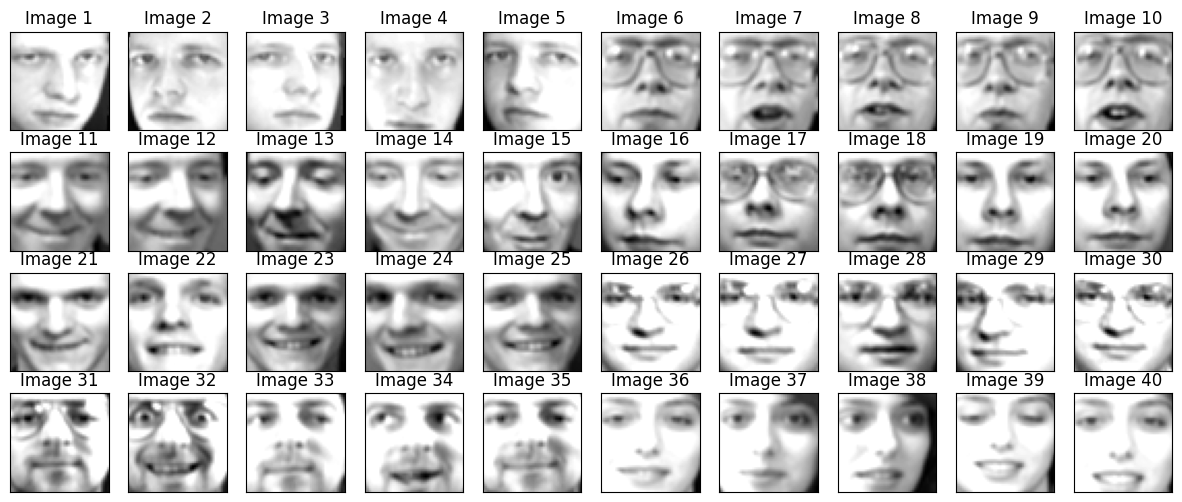

Y_train shape: (200,)
Y_test shape: (200,)
Shape of each image: (48, 48)


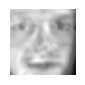

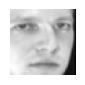

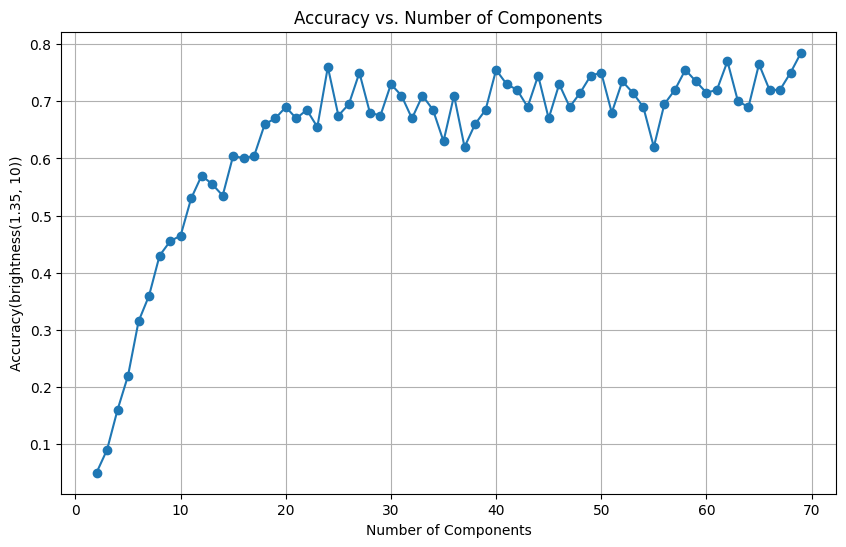

Number of components for the best model: 69
Accuracy: 74.00%
PC Components: 69


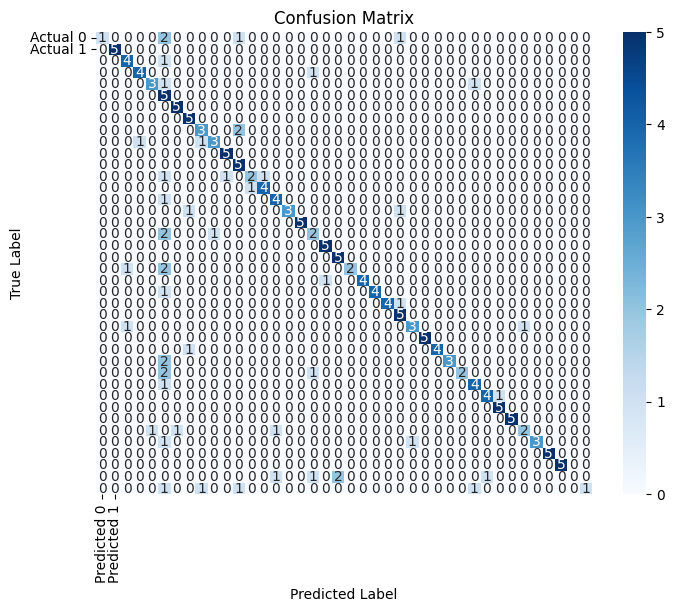

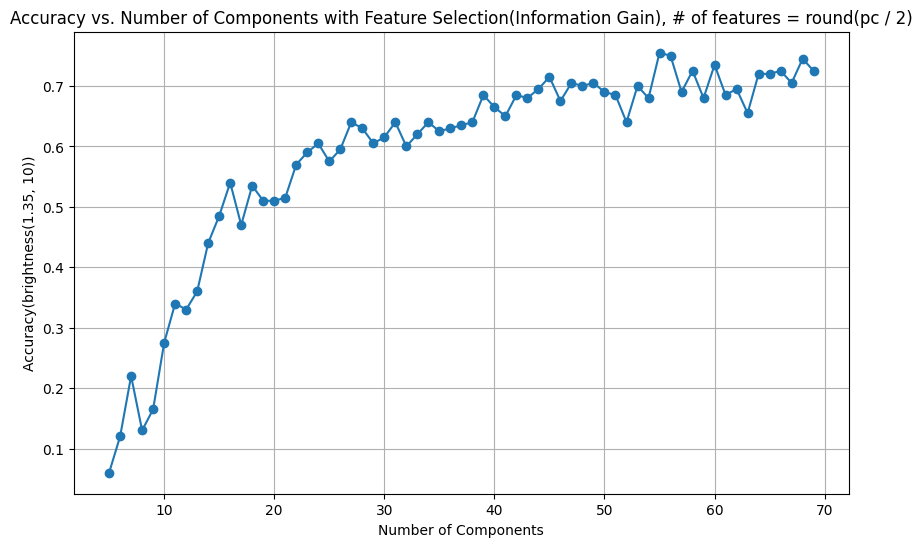

Accuracy: 70.00%
PC Components: 55


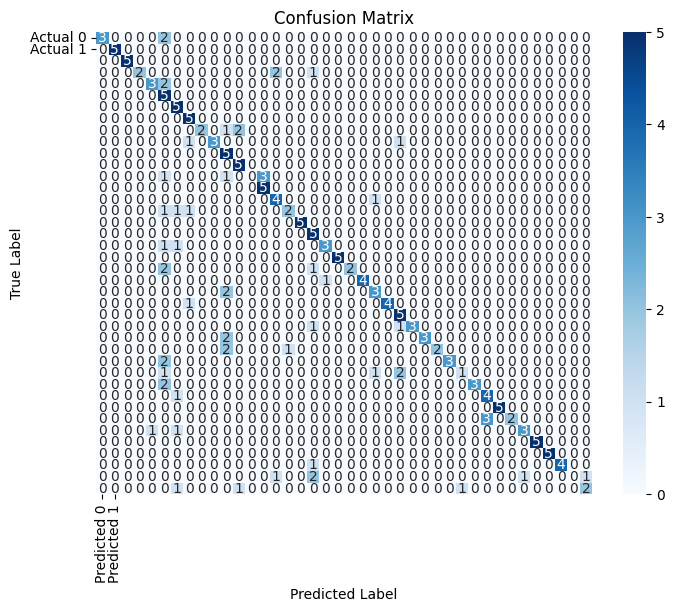

In [2]:
import cv2
import os
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

# Function to adjust brightness of an image
def adjust_brightness(image, alpha=1.35, beta=10):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

# Specify the root path to your dataset directory
root_path = '/content/drive/MyDrive/Colab Notebooks/ORL'

# Create a directory to save the images
output_directory = '/content/drive/MyDrive/Colab Notebooks/all_images'
os.makedirs(output_directory, exist_ok=True)

# Create an empty list to store images
all_images = []

# Loop through each directory (s1, s2, ..., s40)
for i in range(1, 41):
    # Construct the path to the current directory
    current_dir = os.path.join(root_path, f's{i}')

    # Get a list of all files in the current directory
    files = os.listdir(current_dir)

    # Loop through each file in the directory
    for file in files:
        # Construct the full file path
        file_path = os.path.join(current_dir, file)

        # Read the image using OpenCV in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 48x48 pixels
        img_resized = cv2.resize(img, (48, 48))

        # Save the resized and rotated image to the output directory
        output_path = os.path.join(output_directory, f's{i}_{file}')
        cv2.imwrite(output_path, img_resized)

        # Append the resized and rotated image to the list
        all_images.append(img_resized)


# Convert the list of images to a DataFrame
df = pd.DataFrame({'Image': all_images})


# Create empty lists for train and test data
train_data = []
test_data = []

# Number of images per subject for train and test
num_train_images = 5
num_test_images = 5

# Loop through each subject
for i in range(1, 41):
    # Construct the path to the current directory
    current_dir = os.path.join(root_path, f's{i}')

    # Get a list of all files in the current directory
    files = os.listdir(current_dir)

    # Loop through each file in the directory
    for j, file in enumerate(files):
        # Construct the full file path
        file_path = os.path.join(current_dir, file)

        # Read the image using OpenCV in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 48x48 pixels
        img_resized = cv2.resize(img, (48, 48))

        # Check if it's a test image and rotate only the test images
        if j >= num_train_images:
            img_rotated = adjust_brightness(img_resized)
            test_data.append(img_rotated)  # Append to test_data
        else:
            train_data.append(img_resized)  # Append to train_data

# Convert train and test data to DataFrames
df_train = pd.DataFrame({'Image': train_data})
df_test = pd.DataFrame({'Image': test_data})

num_images_to_plot = 40

# Plot the first 40 images
fig, axes = plt.subplots(4, 10, figsize=(15, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(test_data[i], cmap='gray')  # Assuming images are grayscale
    ax.set_title(f"Image {i+1}")

plt.show()

# Number of subjects
num_subjects = 40

# Number of images per subject for train and test
num_train_images = 5
num_test_images = 5

# Create Y_train and Y_test arrays
Y_train = np.repeat(np.arange(1, num_subjects + 1), num_train_images)
Y_test = np.repeat(np.arange(1, num_subjects + 1), num_test_images)

# Verify the shapes
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

image_shape = all_images[0].shape
print("Shape of each image:", image_shape)

import numpy as np

# Function to flatten each image to a vector
def flatten_image(image):
    return image.flatten()

# Apply the flatten_image function to each image in train_data and test_data
train_vectors = [flatten_image(image) for image in train_data]
test_vectors = [flatten_image(image) for image in test_data]

# Convert the lists of vectors to NumPy arrays
x_train_reshaped = np.array(train_vectors)
x_test_reshaped = np.array(test_vectors)

#calculate the covariance matrix and the eigenvalue and eigenvectors of the covariance matrix.
covariance = np.cov(x_train_reshaped.T)

explained_variance = 0.87
U, S, Vh = np.linalg.svd(covariance, full_matrices=True)
#calculate the total variance from eigenvalues and find the first k component that contains the eplained_variance of the total variance.
NormSumOfS = np.cumsum(S)/np.sum(S)
index = np.argmax(NormSumOfS > explained_variance)
V = Vh.T

# here show 50 first of this images
def show_images(num_images,X):
    #inputs dataset and number of images wants to show
    #output plot images
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(5, 10, i + 1)
        plt.imshow(X[i] / 255.0, cmap='gray')
        plt.axis('off')
    plt.show()
#Project Images into Reduced Dimensionality Eigenbasis F=X*V (X is our dataset,F our reduced dimensionality dataset,V is k choosen eigenvectors)
#And Reproject Images to Standard Basis for plotting the reduced component image X_k=F*V_transpose (V_transpose is equal to V inverse)
#select one sample and reshape it to a 28 by 28 matrix and plot them as image
F = np.dot(np.dot(x_train_reshaped,V[:, :index]), V[:, :index].T)
#plot the dimentionally reduced data
#plot the original data
F_reshaped = F.reshape(200, 48, 48)
show_images(1,F_reshaped)
show_images(1,train_data)

from sklearn.decomposition import PCA

def do_pca(n_components, data, data1):
    # Create a PCA instance with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to your data and transform the data
    projected_data = pca.fit_transform(data)
    projected_data1 = pca.transform(data1)
    return projected_data, projected_data1


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

def plot_confusion_matrix(Y_test, Y_pred):
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

def ML_model(X_train, X_test, Y_train, Y_test, print_output=True, pc=1, plot_conf=False):
    # Configure MLP classifier with Adam optimizer and 0.01 learning rate
    model = MLPClassifier(solver='adam', learning_rate_init=0.01, max_iter=300)  # Adjust max_iter if needed

    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    acc = accuracy_score(Y_test, Y_pred)

    if print_output:
        print(f"Accuracy: {acc * 100:.2f}%")
        print(f"PC Components: {pc}")
        
    if plot_conf:
        # Plot confusion matrix
        ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

    return acc

import matplotlib.pyplot as plt

# Initialize lists to store accuracy and number of components
acc_list, pc_list = [], []

for pc in range(2, 70):
    # Perform PCA with the current number of components
    projected_train_data, projected_test_data = do_pca(pc, x_train_reshaped, x_test_reshaped)

    # Train the SVM model and calculate accuracy
    accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, False, pc)

    # Append the accuracy and number of components to the lists
    acc_list.append(accuracy)
    pc_list.append(pc)

# Plot the accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(pc_list, acc_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy(brightness(1.35, 10))')
plt.grid(True)
plt.show()

# Find the index of the maximum accuracy in the acc_list
best_acc_index = acc_list.index(max(acc_list))

# Get the corresponding number of components for the best accuracy
best_pc = pc_list[best_acc_index]

print("Number of components for the best model:", best_pc)

# Perform PCA with the current number of components
projected_train_data, projected_test_data = do_pca(pc, x_train_reshaped, x_test_reshaped)

# Train the SVM model and calculate accuracy
accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, True, best_pc, True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif


def select_features_after_pca(n_components, data, data1, k):
    # Create a PCA instance with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to your data and transform the data
    projected_data = pca.fit_transform(data)
    projected_data1 = pca.transform(data1)

    # Train a RandomForestClassifier on the reduced data to obtain feature importances
    model = RandomForestClassifier(n_estimators=100)
    model.fit(projected_data, Y_train)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Rank features based on importance
    ranked_features = np.argsort(feature_importances)[::-1]

    # Select the top-k features using Information Gain
    k_best = SelectKBest(mutual_info_classif, k=k)
    selected_data = k_best.fit_transform(projected_data, Y_train)
    selected_data1 = k_best.transform(projected_data1)

    return selected_data, selected_data1

# ... (The rest of your code remains unchanged)

# Initialize lists to store accuracy and number of components
acc_list, pc_list = [], []

# Specify the number of features (k) to select after PCA
k_features = 20  # You can adjust this based on your requirements

for pc in range(5, 70):
    # Perform PCA with the current number of components and select features
    selected_train_data, selected_test_data = select_features_after_pca(pc, x_train_reshaped, x_test_reshaped, int(round(pc / 2)))

    # Train the SVM model and calculate accuracy
    accuracy = ML_model(selected_train_data, selected_test_data, Y_train, Y_test, False, pc)

    # Append the accuracy and number of components to the lists
    acc_list.append(accuracy)
    pc_list.append(pc)

# Plot the accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(pc_list, acc_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Components with Feature Selection(Information Gain), # of features = round(pc / 2)')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy(brightness(1.35, 10))')
plt.grid(True)
plt.show()
# Find the index of the maximum accuracy in the acc_list
best_acc_index = acc_list.index(max(acc_list))

# Get the corresponding number of components for the best accuracy
best_pc = pc_list[best_acc_index]

# Perform PCA with the current number of components
projected_train_data, projected_test_data = select_features_after_pca(pc, x_train_reshaped, x_test_reshaped, int(round(best_pc / 2)))

# Train the SVM model and calculate accuracy
accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, True, best_pc, True)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


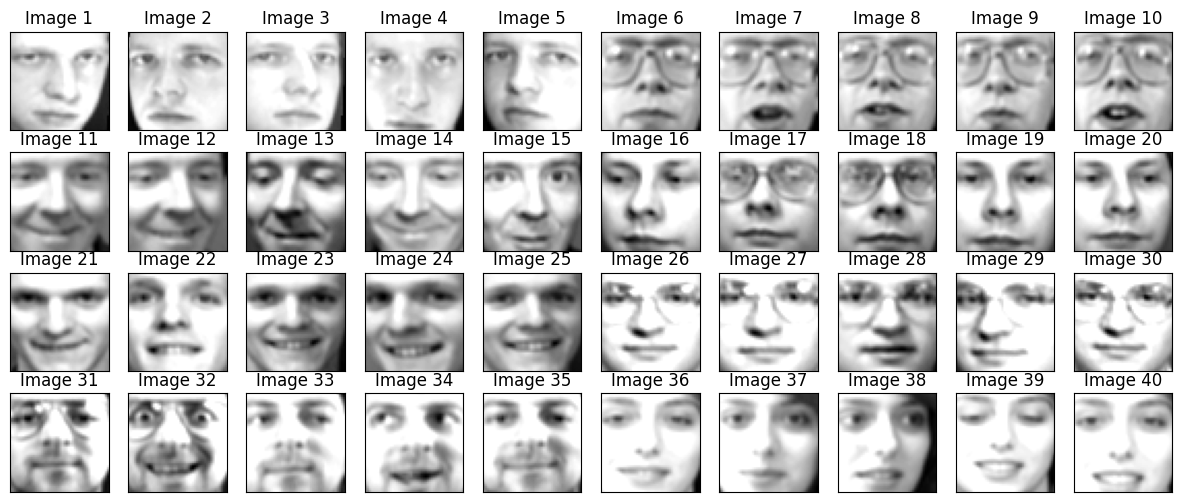

Y_train shape: (200,)
Y_test shape: (200,)
Shape of each image: (48, 48)


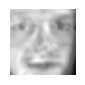

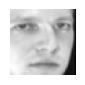

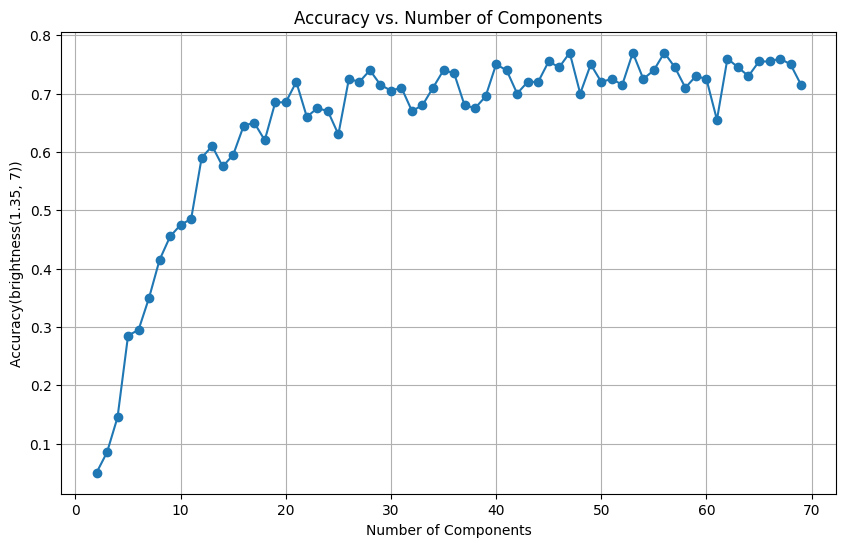

Number of components for the best model: 47
Accuracy: 76.50%
PC Components: 47


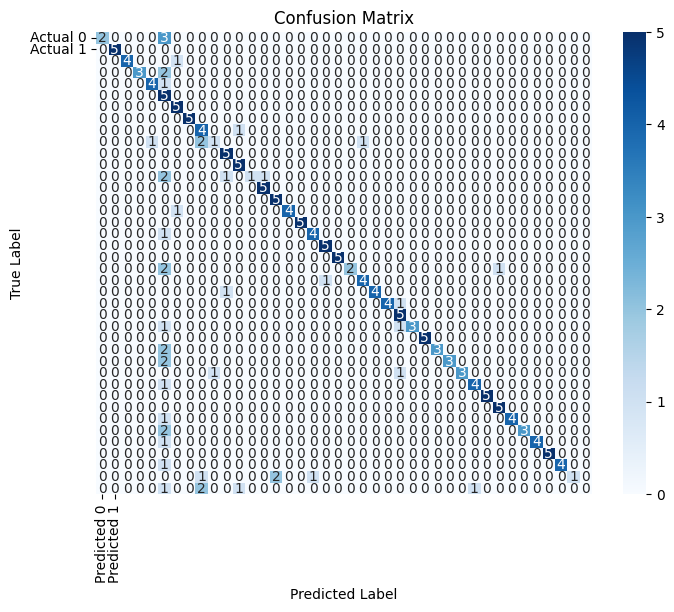

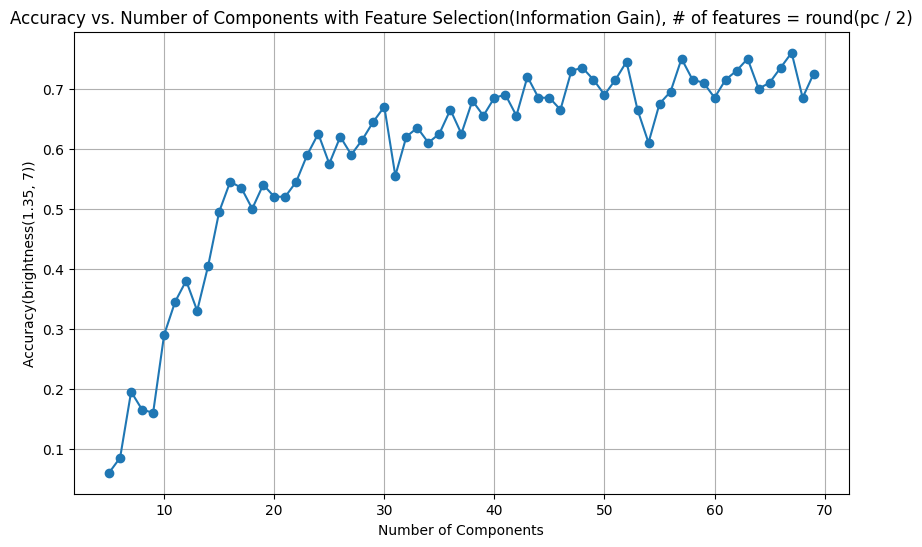

Accuracy: 77.50%
PC Components: 67


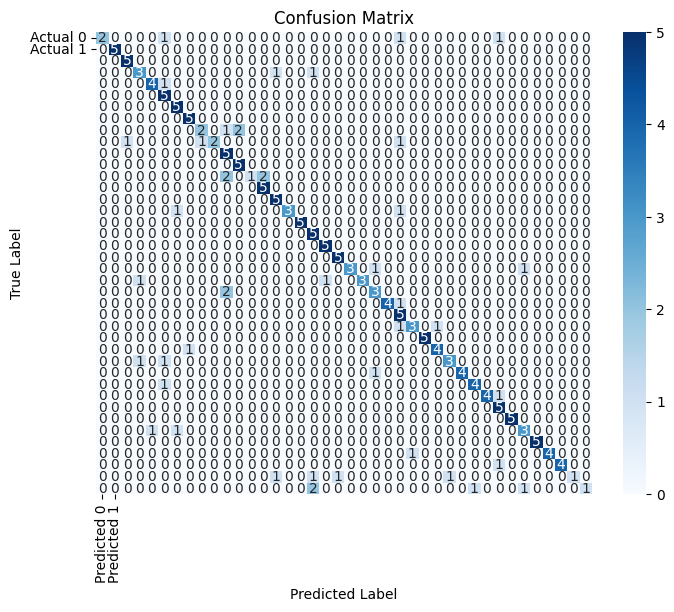

In [3]:
import cv2
import os
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

# Function to adjust brightness of an image
def adjust_brightness(image, alpha=1.35, beta=7):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

# Specify the root path to your dataset directory
root_path = '/content/drive/MyDrive/Colab Notebooks/ORL'

# Create a directory to save the images
output_directory = '/content/drive/MyDrive/Colab Notebooks/all_images'
os.makedirs(output_directory, exist_ok=True)

# Create an empty list to store images
all_images = []

# Loop through each directory (s1, s2, ..., s40)
for i in range(1, 41):
    # Construct the path to the current directory
    current_dir = os.path.join(root_path, f's{i}')

    # Get a list of all files in the current directory
    files = os.listdir(current_dir)

    # Loop through each file in the directory
    for file in files:
        # Construct the full file path
        file_path = os.path.join(current_dir, file)

        # Read the image using OpenCV in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 48x48 pixels
        img_resized = cv2.resize(img, (48, 48))

        # Save the resized and rotated image to the output directory
        output_path = os.path.join(output_directory, f's{i}_{file}')
        cv2.imwrite(output_path, img_resized)

        # Append the resized and rotated image to the list
        all_images.append(img_resized)


# Convert the list of images to a DataFrame
df = pd.DataFrame({'Image': all_images})


# Create empty lists for train and test data
train_data = []
test_data = []

# Number of images per subject for train and test
num_train_images = 5
num_test_images = 5

# Loop through each subject
for i in range(1, 41):
    # Construct the path to the current directory
    current_dir = os.path.join(root_path, f's{i}')

    # Get a list of all files in the current directory
    files = os.listdir(current_dir)

    # Loop through each file in the directory
    for j, file in enumerate(files):
        # Construct the full file path
        file_path = os.path.join(current_dir, file)

        # Read the image using OpenCV in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 48x48 pixels
        img_resized = cv2.resize(img, (48, 48))

        # Check if it's a test image and rotate only the test images
        if j >= num_train_images:
            img_rotated = adjust_brightness(img_resized)
            test_data.append(img_rotated)  # Append to test_data
        else:
            train_data.append(img_resized)  # Append to train_data

# Convert train and test data to DataFrames
df_train = pd.DataFrame({'Image': train_data})
df_test = pd.DataFrame({'Image': test_data})

num_images_to_plot = 40

# Plot the first 40 images
fig, axes = plt.subplots(4, 10, figsize=(15, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(test_data[i], cmap='gray')  # Assuming images are grayscale
    ax.set_title(f"Image {i+1}")

plt.show()

# Number of subjects
num_subjects = 40

# Number of images per subject for train and test
num_train_images = 5
num_test_images = 5

# Create Y_train and Y_test arrays
Y_train = np.repeat(np.arange(1, num_subjects + 1), num_train_images)
Y_test = np.repeat(np.arange(1, num_subjects + 1), num_test_images)

# Verify the shapes
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

image_shape = all_images[0].shape
print("Shape of each image:", image_shape)

import numpy as np

# Function to flatten each image to a vector
def flatten_image(image):
    return image.flatten()

# Apply the flatten_image function to each image in train_data and test_data
train_vectors = [flatten_image(image) for image in train_data]
test_vectors = [flatten_image(image) for image in test_data]

# Convert the lists of vectors to NumPy arrays
x_train_reshaped = np.array(train_vectors)
x_test_reshaped = np.array(test_vectors)

#calculate the covariance matrix and the eigenvalue and eigenvectors of the covariance matrix.
covariance = np.cov(x_train_reshaped.T)

explained_variance = 0.87
U, S, Vh = np.linalg.svd(covariance, full_matrices=True)
#calculate the total variance from eigenvalues and find the first k component that contains the eplained_variance of the total variance.
NormSumOfS = np.cumsum(S)/np.sum(S)
index = np.argmax(NormSumOfS > explained_variance)
V = Vh.T

# here show 50 first of this images
def show_images(num_images,X):
    #inputs dataset and number of images wants to show
    #output plot images
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(5, 10, i + 1)
        plt.imshow(X[i] / 255.0, cmap='gray')
        plt.axis('off')
    plt.show()
#Project Images into Reduced Dimensionality Eigenbasis F=X*V (X is our dataset,F our reduced dimensionality dataset,V is k choosen eigenvectors)
#And Reproject Images to Standard Basis for plotting the reduced component image X_k=F*V_transpose (V_transpose is equal to V inverse)
#select one sample and reshape it to a 28 by 28 matrix and plot them as image
F = np.dot(np.dot(x_train_reshaped,V[:, :index]), V[:, :index].T)
#plot the dimentionally reduced data
#plot the original data
F_reshaped = F.reshape(200, 48, 48)
show_images(1,F_reshaped)
show_images(1,train_data)

from sklearn.decomposition import PCA

def do_pca(n_components, data, data1):
    # Create a PCA instance with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to your data and transform the data
    projected_data = pca.fit_transform(data)
    projected_data1 = pca.transform(data1)
    return projected_data, projected_data1


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

def plot_confusion_matrix(Y_test, Y_pred):
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

def ML_model(X_train, X_test, Y_train, Y_test, print_output=True, pc=1, plot_conf=False):
    # Configure MLP classifier with Adam optimizer and 0.01 learning rate
    model = MLPClassifier(solver='adam', learning_rate_init=0.01, max_iter=300)  # Adjust max_iter if needed

    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    acc = accuracy_score(Y_test, Y_pred)

    if print_output:
        print(f"Accuracy: {acc * 100:.2f}%")
        print(f"PC Components: {pc}")
        
    if plot_conf:
        # Plot confusion matrix
        ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

    return acc

import matplotlib.pyplot as plt

# Initialize lists to store accuracy and number of components
acc_list, pc_list = [], []

for pc in range(2, 70):
    # Perform PCA with the current number of components
    projected_train_data, projected_test_data = do_pca(pc, x_train_reshaped, x_test_reshaped)

    # Train the SVM model and calculate accuracy
    accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, False, pc)

    # Append the accuracy and number of components to the lists
    acc_list.append(accuracy)
    pc_list.append(pc)

# Plot the accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(pc_list, acc_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy(brightness(1.35, 7))')
plt.grid(True)
plt.show()

# Find the index of the maximum accuracy in the acc_list
best_acc_index = acc_list.index(max(acc_list))

# Get the corresponding number of components for the best accuracy
best_pc = pc_list[best_acc_index]

print("Number of components for the best model:", best_pc)

# Perform PCA with the current number of components
projected_train_data, projected_test_data = do_pca(pc, x_train_reshaped, x_test_reshaped)

# Train the SVM model and calculate accuracy
accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, True, best_pc, True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif


def select_features_after_pca(n_components, data, data1, k):
    # Create a PCA instance with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to your data and transform the data
    projected_data = pca.fit_transform(data)
    projected_data1 = pca.transform(data1)

    # Train a RandomForestClassifier on the reduced data to obtain feature importances
    model = RandomForestClassifier(n_estimators=100)
    model.fit(projected_data, Y_train)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Rank features based on importance
    ranked_features = np.argsort(feature_importances)[::-1]

    # Select the top-k features using Information Gain
    k_best = SelectKBest(mutual_info_classif, k=k)
    selected_data = k_best.fit_transform(projected_data, Y_train)
    selected_data1 = k_best.transform(projected_data1)

    return selected_data, selected_data1

# ... (The rest of your code remains unchanged)

# Initialize lists to store accuracy and number of components
acc_list, pc_list = [], []

# Specify the number of features (k) to select after PCA
k_features = 20  # You can adjust this based on your requirements

for pc in range(5, 70):
    # Perform PCA with the current number of components and select features
    selected_train_data, selected_test_data = select_features_after_pca(pc, x_train_reshaped, x_test_reshaped, int(round(pc / 2)))

    # Train the SVM model and calculate accuracy
    accuracy = ML_model(selected_train_data, selected_test_data, Y_train, Y_test, False, pc)

    # Append the accuracy and number of components to the lists
    acc_list.append(accuracy)
    pc_list.append(pc)

# Plot the accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(pc_list, acc_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Components with Feature Selection(Information Gain), # of features = round(pc / 2)')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy(brightness(1.35, 7))')
plt.grid(True)
plt.show()
# Find the index of the maximum accuracy in the acc_list
best_acc_index = acc_list.index(max(acc_list))

# Get the corresponding number of components for the best accuracy
best_pc = pc_list[best_acc_index]

# Perform PCA with the current number of components
projected_train_data, projected_test_data = select_features_after_pca(pc, x_train_reshaped, x_test_reshaped, int(round(best_pc / 2)))

# Train the SVM model and calculate accuracy
accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, True, best_pc, True)


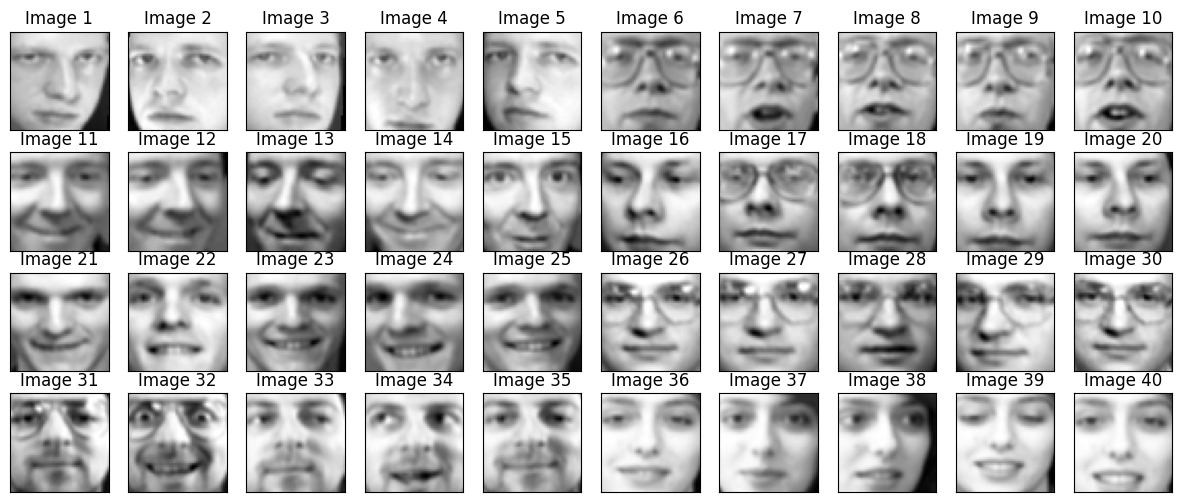

Y_train shape: (200,)
Y_test shape: (200,)
Shape of each image: (48, 48)


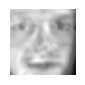

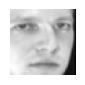

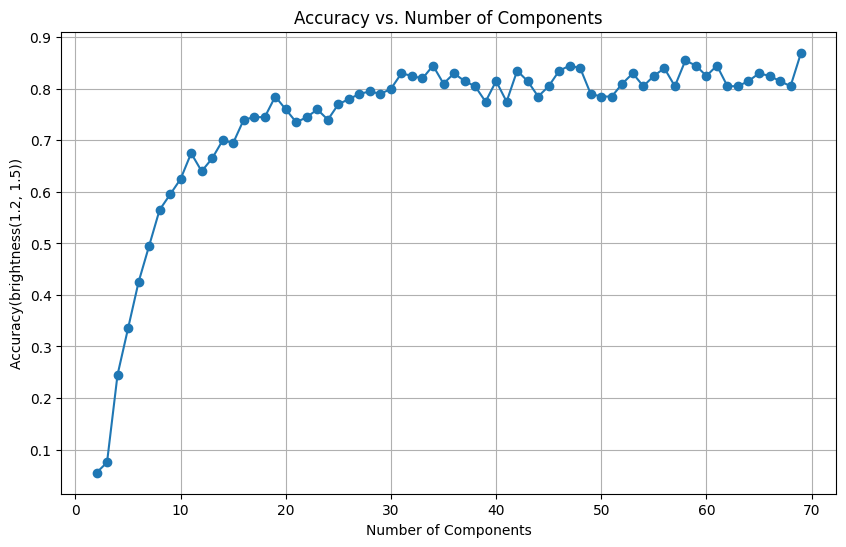

Number of components for the best model: 69
Accuracy: 80.50%
PC Components: 69


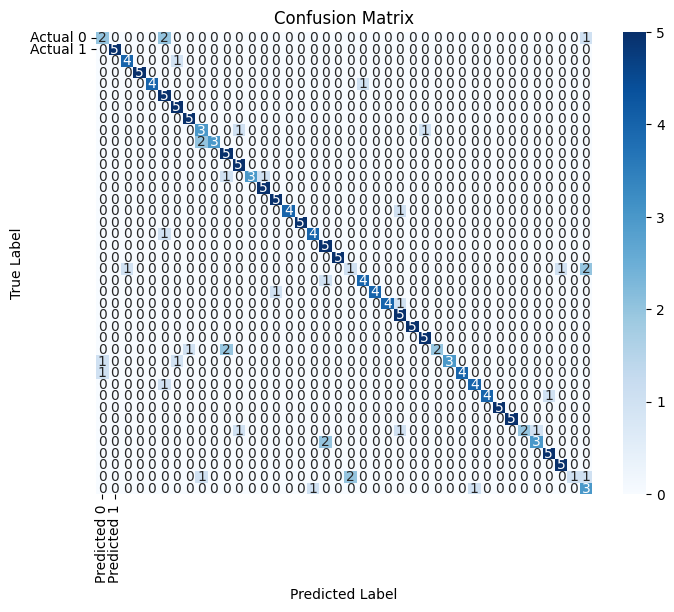

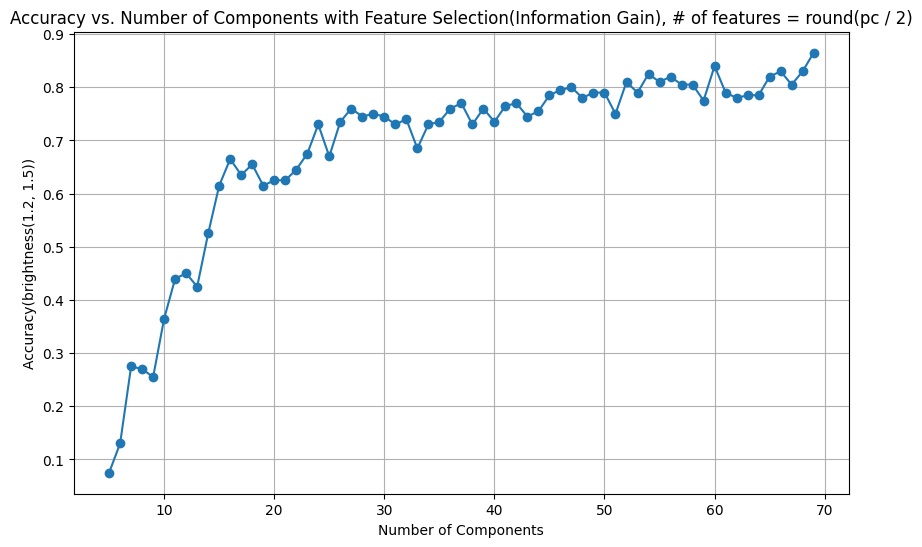

Accuracy: 78.50%
PC Components: 69


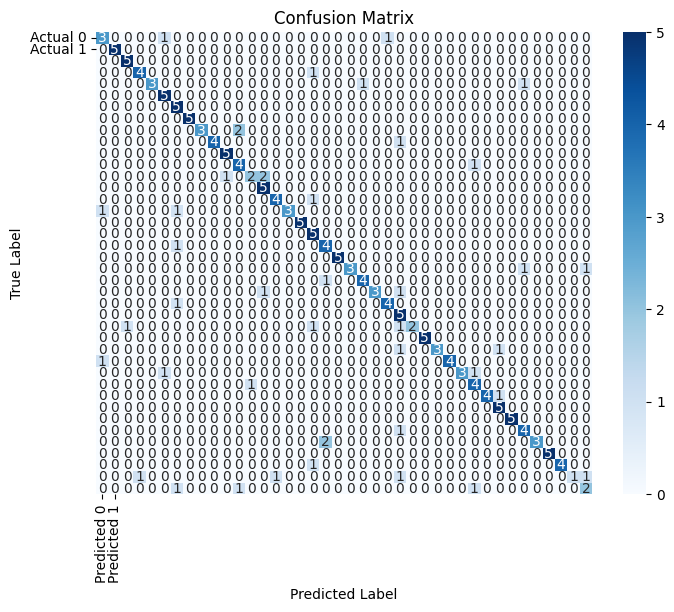

In [4]:
import cv2
import os
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

# Function to adjust brightness of an image
def adjust_brightness(image, alpha=1.2, beta=1.5):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

# Specify the root path to your dataset directory
root_path = '/content/drive/MyDrive/Colab Notebooks/ORL'

# Create a directory to save the images
output_directory = '/content/drive/MyDrive/Colab Notebooks/all_images'
os.makedirs(output_directory, exist_ok=True)

# Create an empty list to store images
all_images = []

# Loop through each directory (s1, s2, ..., s40)
for i in range(1, 41):
    # Construct the path to the current directory
    current_dir = os.path.join(root_path, f's{i}')

    # Get a list of all files in the current directory
    files = os.listdir(current_dir)

    # Loop through each file in the directory
    for file in files:
        # Construct the full file path
        file_path = os.path.join(current_dir, file)

        # Read the image using OpenCV in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 48x48 pixels
        img_resized = cv2.resize(img, (48, 48))

        # Save the resized and rotated image to the output directory
        output_path = os.path.join(output_directory, f's{i}_{file}')
        cv2.imwrite(output_path, img_resized)

        # Append the resized and rotated image to the list
        all_images.append(img_resized)


# Convert the list of images to a DataFrame
df = pd.DataFrame({'Image': all_images})


# Create empty lists for train and test data
train_data = []
test_data = []

# Number of images per subject for train and test
num_train_images = 5
num_test_images = 5

# Loop through each subject
for i in range(1, 41):
    # Construct the path to the current directory
    current_dir = os.path.join(root_path, f's{i}')

    # Get a list of all files in the current directory
    files = os.listdir(current_dir)

    # Loop through each file in the directory
    for j, file in enumerate(files):
        # Construct the full file path
        file_path = os.path.join(current_dir, file)

        # Read the image using OpenCV in grayscale
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to 48x48 pixels
        img_resized = cv2.resize(img, (48, 48))

        # Check if it's a test image and rotate only the test images
        if j >= num_train_images:
            img_rotated = adjust_brightness(img_resized)
            test_data.append(img_rotated)  # Append to test_data
        else:
            train_data.append(img_resized)  # Append to train_data

# Convert train and test data to DataFrames
df_train = pd.DataFrame({'Image': train_data})
df_test = pd.DataFrame({'Image': test_data})

num_images_to_plot = 40

# Plot the first 40 images
fig, axes = plt.subplots(4, 10, figsize=(15, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(test_data[i], cmap='gray')  # Assuming images are grayscale
    ax.set_title(f"Image {i+1}")

plt.show()

# Number of subjects
num_subjects = 40

# Number of images per subject for train and test
num_train_images = 5
num_test_images = 5

# Create Y_train and Y_test arrays
Y_train = np.repeat(np.arange(1, num_subjects + 1), num_train_images)
Y_test = np.repeat(np.arange(1, num_subjects + 1), num_test_images)

# Verify the shapes
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

image_shape = all_images[0].shape
print("Shape of each image:", image_shape)

import numpy as np

# Function to flatten each image to a vector
def flatten_image(image):
    return image.flatten()

# Apply the flatten_image function to each image in train_data and test_data
train_vectors = [flatten_image(image) for image in train_data]
test_vectors = [flatten_image(image) for image in test_data]

# Convert the lists of vectors to NumPy arrays
x_train_reshaped = np.array(train_vectors)
x_test_reshaped = np.array(test_vectors)

#calculate the covariance matrix and the eigenvalue and eigenvectors of the covariance matrix.
covariance = np.cov(x_train_reshaped.T)

explained_variance = 0.87
U, S, Vh = np.linalg.svd(covariance, full_matrices=True)
#calculate the total variance from eigenvalues and find the first k component that contains the eplained_variance of the total variance.
NormSumOfS = np.cumsum(S)/np.sum(S)
index = np.argmax(NormSumOfS > explained_variance)
V = Vh.T

# here show 50 first of this images
def show_images(num_images,X):
    #inputs dataset and number of images wants to show
    #output plot images
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(5, 10, i + 1)
        plt.imshow(X[i] / 255.0, cmap='gray')
        plt.axis('off')
    plt.show()
#Project Images into Reduced Dimensionality Eigenbasis F=X*V (X is our dataset,F our reduced dimensionality dataset,V is k choosen eigenvectors)
#And Reproject Images to Standard Basis for plotting the reduced component image X_k=F*V_transpose (V_transpose is equal to V inverse)
#select one sample and reshape it to a 28 by 28 matrix and plot them as image
F = np.dot(np.dot(x_train_reshaped,V[:, :index]), V[:, :index].T)
#plot the dimentionally reduced data
#plot the original data
F_reshaped = F.reshape(200, 48, 48)
show_images(1,F_reshaped)
show_images(1,train_data)

from sklearn.decomposition import PCA

def do_pca(n_components, data, data1):
    # Create a PCA instance with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to your data and transform the data
    projected_data = pca.fit_transform(data)
    projected_data1 = pca.transform(data1)
    return projected_data, projected_data1


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

def plot_confusion_matrix(Y_test, Y_pred):
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

def ML_model(X_train, X_test, Y_train, Y_test, print_output=True, pc=1, plot_conf=False):
    # Configure MLP classifier with Adam optimizer and 0.01 learning rate
    model = MLPClassifier(solver='adam', learning_rate_init=0.01, max_iter=300)  # Adjust max_iter if needed

    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    acc = accuracy_score(Y_test, Y_pred)

    if print_output:
        print(f"Accuracy: {acc * 100:.2f}%")
        print(f"PC Components: {pc}")
        
    if plot_conf:
        # Plot confusion matrix
        ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

    return acc

import matplotlib.pyplot as plt

# Initialize lists to store accuracy and number of components
acc_list, pc_list = [], []

for pc in range(2, 70):
    # Perform PCA with the current number of components
    projected_train_data, projected_test_data = do_pca(pc, x_train_reshaped, x_test_reshaped)

    # Train the SVM model and calculate accuracy
    accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, False, pc)

    # Append the accuracy and number of components to the lists
    acc_list.append(accuracy)
    pc_list.append(pc)

# Plot the accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(pc_list, acc_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy(brightness(1.2, 1.5))')
plt.grid(True)
plt.show()

# Find the index of the maximum accuracy in the acc_list
best_acc_index = acc_list.index(max(acc_list))

# Get the corresponding number of components for the best accuracy
best_pc = pc_list[best_acc_index]

print("Number of components for the best model:", best_pc)

# Perform PCA with the current number of components
projected_train_data, projected_test_data = do_pca(pc, x_train_reshaped, x_test_reshaped)

# Train the SVM model and calculate accuracy
accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, True, best_pc, True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif


def select_features_after_pca(n_components, data, data1, k):
    # Create a PCA instance with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to your data and transform the data
    projected_data = pca.fit_transform(data)
    projected_data1 = pca.transform(data1)

    # Train a RandomForestClassifier on the reduced data to obtain feature importances
    model = RandomForestClassifier(n_estimators=100)
    model.fit(projected_data, Y_train)

    # Get feature importances
    feature_importances = model.feature_importances_

    # Rank features based on importance
    ranked_features = np.argsort(feature_importances)[::-1]

    # Select the top-k features using Information Gain
    k_best = SelectKBest(mutual_info_classif, k=k)
    selected_data = k_best.fit_transform(projected_data, Y_train)
    selected_data1 = k_best.transform(projected_data1)

    return selected_data, selected_data1

# ... (The rest of your code remains unchanged)

# Initialize lists to store accuracy and number of components
acc_list, pc_list = [], []

# Specify the number of features (k) to select after PCA
k_features = 20  # You can adjust this based on your requirements

for pc in range(5, 70):
    # Perform PCA with the current number of components and select features
    selected_train_data, selected_test_data = select_features_after_pca(pc, x_train_reshaped, x_test_reshaped, int(round(pc / 2)))

    # Train the SVM model and calculate accuracy
    accuracy = ML_model(selected_train_data, selected_test_data, Y_train, Y_test, False, pc)

    # Append the accuracy and number of components to the lists
    acc_list.append(accuracy)
    pc_list.append(pc)

# Plot the accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(pc_list, acc_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Components with Feature Selection(Information Gain), # of features = round(pc / 2)')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy(brightness(1.2, 1.5))')
plt.grid(True)
plt.show()
# Find the index of the maximum accuracy in the acc_list
best_acc_index = acc_list.index(max(acc_list))

# Get the corresponding number of components for the best accuracy
best_pc = pc_list[best_acc_index]

# Perform PCA with the current number of components
projected_train_data, projected_test_data = select_features_after_pca(pc, x_train_reshaped, x_test_reshaped, int(round(best_pc / 2)))

# Train the SVM model and calculate accuracy
accuracy = ML_model(projected_train_data, projected_test_data, Y_train, Y_test, True, best_pc, True)
